In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import zipfile

In [2]:
import xarray as xr
import rioxarray as rxr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import earthpy as et
import regionmask
import contextily as cx

In [3]:
from utils.constants import *
from utils.countries import *
from utils.functions import *

In [4]:
os.chdir(ABSOLUTE_FOLDER_REPOSITORY)

In [5]:
nuts = load_nuts_mask(level=3, subset=EU)

## Standardized Precipitation Index (SPI)

In [6]:
folder_spi = os.path.join(FOLDER_CLIMATE_DATA, 'spi')

spi_accumulation_periods = [str(x).zfill(2) for x in [1, 3, 6, 12]]
years = [str(x).zfill(2) for x in range(2001, 2019)]

df_spi = pd.DataFrame(columns=['NUTS_ID', 'TIMESTAMP'])
for i, spi_accumulation_period in enumerate(spi_accumulation_periods):
    for j, year in enumerate(years):

        filename_spi = f'spa{spi_accumulation_period}_NUTS3_MEDIAN_{year}.csv'

        df_spi_temp_year = pd.read_csv(os.path.join(folder_spi, filename_spi))
        df_spi_temp_year.columns = [x.strip() for x in df_spi_temp_year.columns.tolist()]
        df_spi_temp_year = df_spi_temp_year.rename(columns={'MEDIAN': f'spi{spi_accumulation_period}'})

        if j == 0:
            df_spi_temp = df_spi_temp_year.copy()
        else:
            df_spi_temp = pd.concat([df_spi_temp, df_spi_temp_year], axis=0)

    if i == 0:
        df_spi = df_spi_temp.copy()
    else:
        df_spi = pd.merge(df_spi, df_spi_temp, how='left', on=['NUTS_ID', 'TIMESTAMP'])

In [7]:
df_spi['YEAR'] = df_spi.TIMESTAMP.str[:4]
df_spi['MONTH'] = df_spi.TIMESTAMP.str[5:7]
df_spi.head()

NUTS_ID   TIMESTAMP   spi01   spi03   spi06   spi12  YEAR MONTH
0   AL011  2001-01-01  0.1130 -0.2670 -0.9130 -1.0900  2001    01
1   AL012  2001-01-01  0.2905  0.3215 -0.5500 -0.7295  2001    01
2   AL013  2001-01-01  0.3270 -0.0620 -0.2765 -0.8495  2001    01
3   AL014  2001-01-01  0.3320  0.1080 -0.2270 -0.5860  2001    01
4   AL015  2001-01-01  0.5720  0.5610  0.4480 -0.2130  2001    01

In [8]:
months_subset = [str(x).zfill(2) for x in range(1, 13)]
df_spi_agg = df_spi[df_spi.MONTH.isin(months_subset)]
df_spi_agg = df_spi_agg.groupby(['NUTS_ID','YEAR'])[['spi01', 'spi03', 'spi06', 'spi12']].mean().reset_index()

In [9]:
df_spi_agg.head()

NUTS_ID  YEAR     spi01     spi03     spi06     spi12
0   AL011  2001  0.035167 -0.090917 -0.251667 -0.631667
1   AL011  2002  0.109000  0.163917  0.033083 -0.625750
2   AL011  2003 -0.370917 -0.346083 -0.301750  0.229250
3   AL011  2004  0.599667  0.724333  1.088083  1.171667
4   AL011  2005  0.359083  0.242167  0.259833  0.492667

In [10]:
df = nuts.merge(df_spi_agg, on='NUTS_ID')
df = df.dropna()

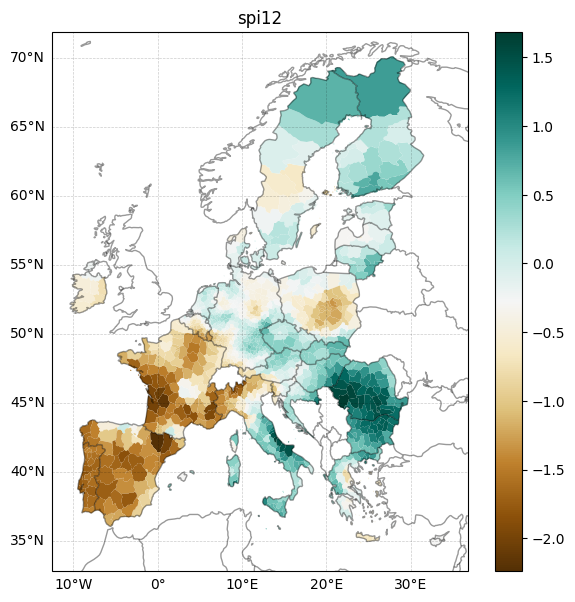

In [11]:
year_to_plot = 2005
plot_map(
    df[df.YEAR == str(year_to_plot)],
    'spi12',
    cmap = 'BrBG'
)

## Low-Flow Index (LFI)

In [6]:
folder_lfi = os.path.join(FOLDER_CLIMATE_DATA, 'low_flow_index')

years = [str(x).zfill(2) for x in range(2001, 2019)]

df_lfi = pd.DataFrame(columns=['NUTS_ID', 'TIMESTAMP'])
for i, year in enumerate(years):

    filename_lfi = f'lfinx_NUTS3_MAX_{year}.csv'

    df_lfi_temp = pd.read_csv(os.path.join(folder_lfi, filename_lfi))
    df_lfi_temp.columns = [x.strip() for x in df_lfi_temp.columns.tolist()]
    df_lfi_temp = df_lfi_temp.rename(columns={'MONTHLY_MAX': 'lfi'})

    if i == 0:
        df_lfi = df_lfi_temp.copy()
    else:
        df_lfi = pd.concat([df_lfi, df_lfi_temp], axis=0)

In [7]:
df_lfi['YEAR'] = df_lfi.TIMESTAMP.str[:4]
df_lfi['MONTH'] = df_lfi.TIMESTAMP.str[5:7]
df_lfi.head()

NUTS_ID   TIMESTAMP  lfi  YEAR MONTH
0   AL011  2001-01-01  0.0  2001    01
1   AL013  2001-01-01  0.0  2001    01
2   AL014  2001-01-01  0.0  2001    01
3   AL015  2001-01-01  0.0  2001    01
4   AL021  2001-01-01  0.0  2001    01

In [8]:
months_subset = [str(x).zfill(2) for x in range(1, 13)]
df_lfi_agg = df_lfi[df_lfi.MONTH.isin(months_subset)]
df_lfi_agg = df_lfi_agg.groupby(['NUTS_ID','YEAR'])[['lfi']].mean().reset_index()

In [9]:
df_lfi_agg.head()

NUTS_ID  YEAR       lfi
0   AL011  2001  0.248333
1   AL011  2002  0.163000
2   AL011  2003  0.181000
3   AL011  2004  0.000000
4   AL011  2005  0.076667

In [10]:
df = nuts.merge(df_lfi_agg, on='NUTS_ID')
df = df.dropna()

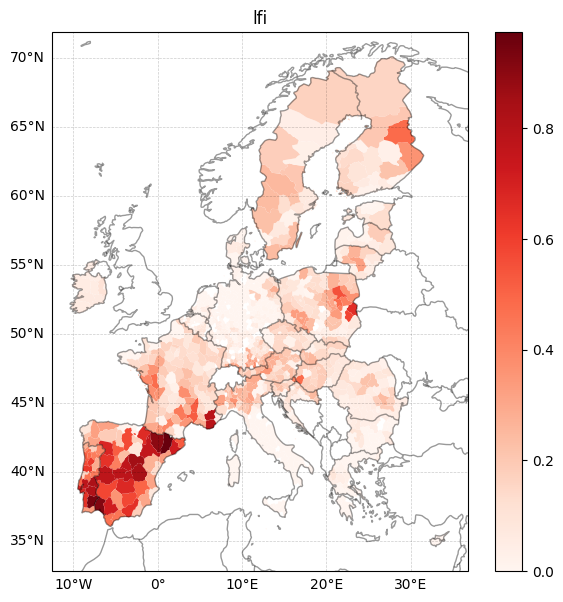

In [11]:
year_to_plot = 2005
plot_map(
    df[df.YEAR == str(year_to_plot)],
    'lfi',
    cmap = 'Reds'
)

## Maximum temperature (TMAX)

In [12]:
folder_tmax = os.path.join(FOLDER_CLIMATE_DATA, 'temp_max')

years = [str(x).zfill(2) for x in range(2001, 2019)]

df_tmax = pd.DataFrame(columns=['NUTS_ID', 'TIMESTAMP'])
for i, year in enumerate(years):

    filename_tmax = f'tpmax_NUTS3_MEDIAN_{year}.csv'

    df_tmax_temp = pd.read_csv(os.path.join(folder_tmax, filename_tmax))
    df_tmax_temp.columns = [x.strip() for x in df_tmax_temp.columns.tolist()]
    df_tmax_temp = df_tmax_temp.rename(columns={'MEDIAN': 'tmax', 'NUTS_CODE': 'NUTS_ID'})

    if i == 0:
        df_tmax = df_tmax_temp.copy()
    else:
        df_tmax = pd.concat([df_tmax, df_tmax_temp], axis=0)

In [13]:
df_tmax['YEAR'] = df_tmax.TIMESTAMP.str[:4]
df_tmax['MONTH'] = df_tmax.TIMESTAMP.str[5:7]
df_tmax.head()

NUTS_ID   TIMESTAMP    tmax  YEAR MONTH
0   AL011  2001-01-01   5.730  2001    01
1   AL012  2001-01-01  13.260  2001    01
2   AL013  2001-01-01   3.682  2001    01
3   AL014  2001-01-01   9.742  2001    01
4   AL015  2001-01-01   7.825  2001    01

In [14]:
months_subset = [str(x).zfill(2) for x in range(1, 13)]
df_tmax_agg = df_tmax[df_tmax.MONTH.isin(months_subset)]
df_tmax_agg = df_tmax_agg.groupby(['NUTS_ID','YEAR'])[['tmax']].mean().reset_index()

In [15]:
df_tmax_agg.head()

NUTS_ID  YEAR       tmax
0   AL011  2001  15.288750
1   AL011  2002  14.994833
2   AL011  2003  15.456167
3   AL011  2004  14.754667
4   AL011  2005  13.819500

In [16]:
df = nuts.merge(df_tmax_agg, on='NUTS_ID')
df = df.dropna()

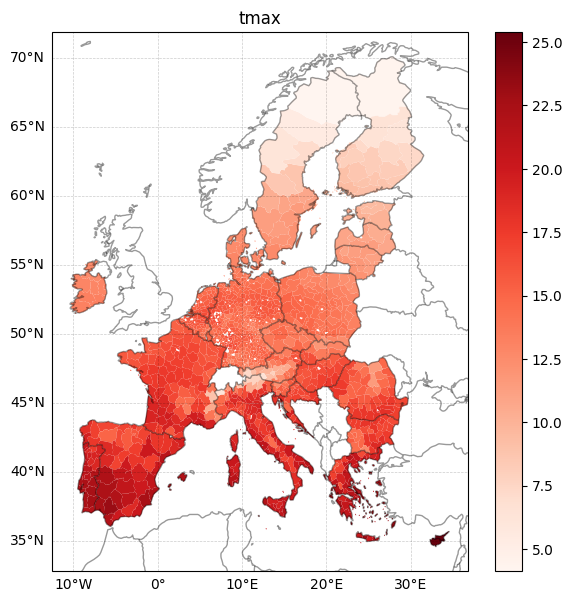

In [17]:
year_to_plot = 2018
plot_map(
    df[df.YEAR == str(year_to_plot)],
    'tmax',
    cmap = 'Reds'
)

In [ ]:
## Maximum temperature (TMAX)